In [1]:
%pylab inline

from smlm_dl import model, dataset, simulate
from importlib import reload

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import skimage

Populating the interactive namespace from numpy and matplotlib


[-31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5
 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5
  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5
   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5
  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5
  28.5  29.5  30.5  31.5]
45:	 [id = 45.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = 13.500,],
22:	 [id = 22.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = -9.500,],
59:	 [id = 59.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = 27.500,],
4:	 [id = 4.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = -27.500,],
38:	 [id = 38.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = 6.500,],
5:	 [id = 5.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = -26.500,],
46:	 [id = 46.000,], [A = 1.000,], [bg = 0.000,], [x =

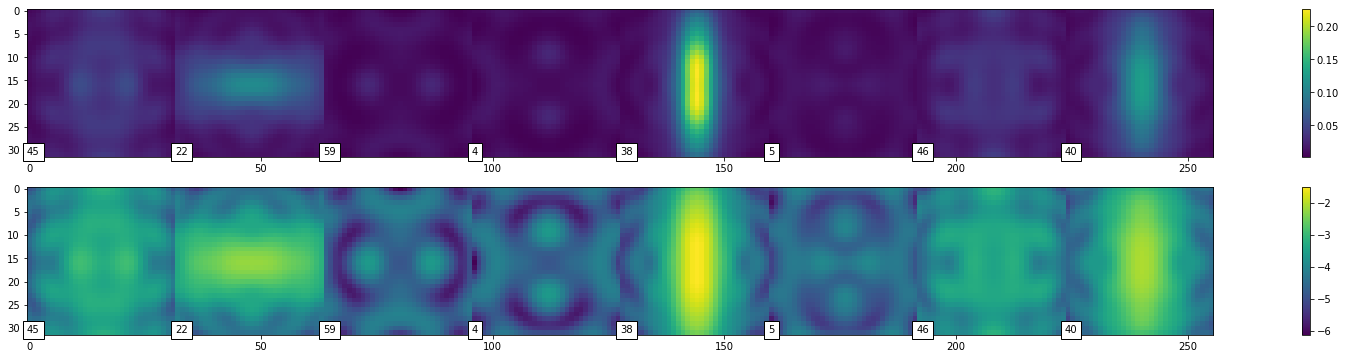

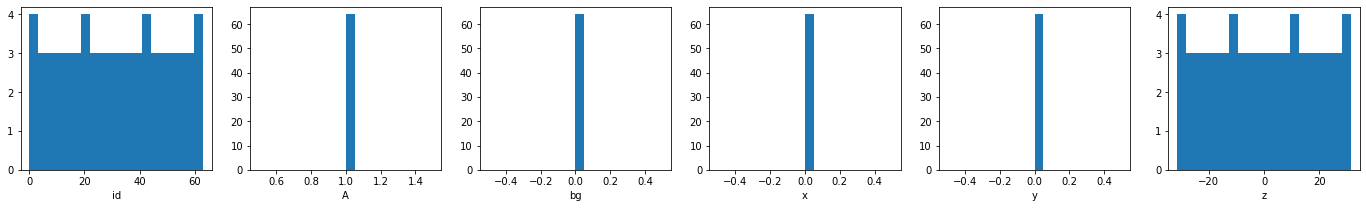

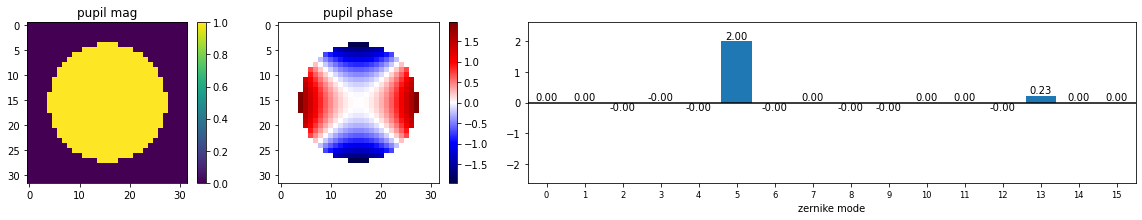

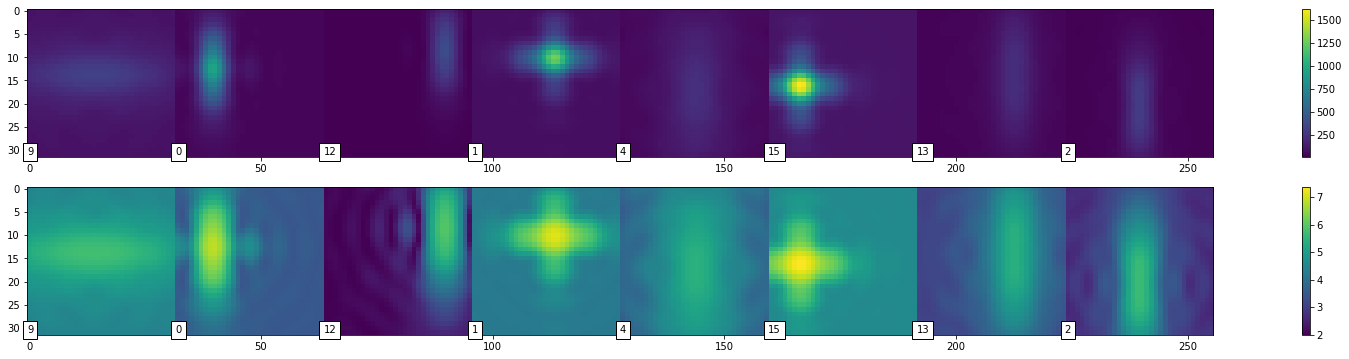

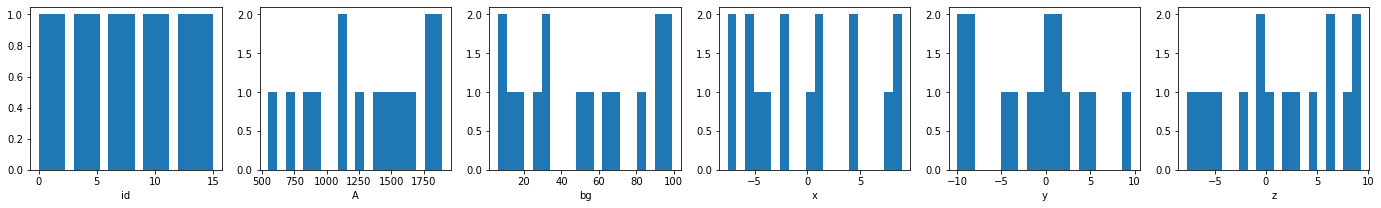

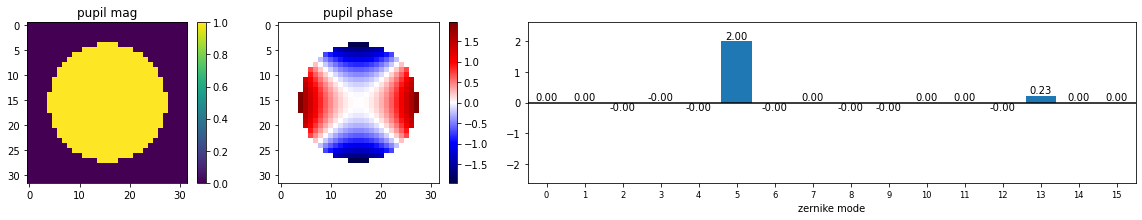

In [2]:
reload(dataset)

psf_zerns = {1:0, 5:2}

length = 64
image_params_preset = {'A': np.ones(length),
                       'x': np.zeros(length),
                       'y': np.zeros(length),
                       'bg': np.zeros(length),
                       'z': np.linspace(-31.5, 31.5, length)}
print(image_params_preset['z'])
reference_psf_data = dataset.FourierOpticsPSFDataset(length=length,
                                                     psf_zerns=psf_zerns,
                                                     noise_params={},
                                                     normalize=False,
                                                     image_params_preset=image_params_preset)
dataset.inspect_images(reference_psf_data)

training_data = dataset.FourierOpticsPSFDataset(length=16,
                                                psf_params={'z':[-10,10]},
                                      psf_zerns={1:0, 5:2},
                                      noise_params={},
                                      normalize=False,
                                     # psf_params={'pupil_scale':1},
                                     ) #psf_zerns={4:0, 5:0.5, 7:1})
dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                  Output Shape              Param #
ConvImageEncoderModel                    --                        --
├─ModuleDict (encoders)                  --                        --
│    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│    │    └─Conv2d (0)                   [32, 32, 16, 16]          4,640
│    │    └─GELU (1)                     [32, 32, 16, 16]          --
│    │    └─Conv2d (2)                   [32, 32, 16, 16]          9,248
│    

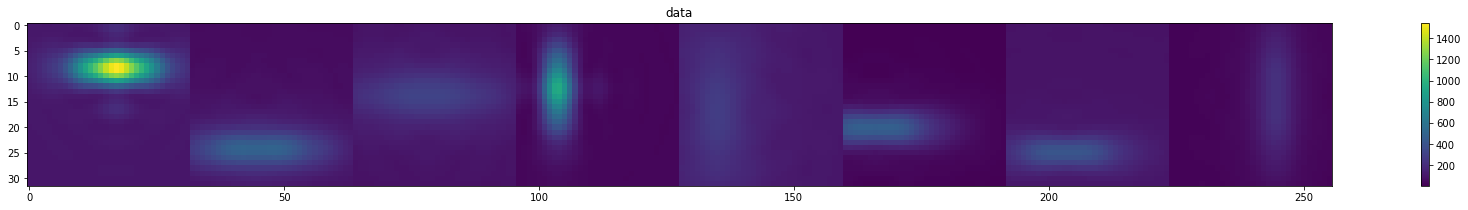

In [3]:
reload(model)
encoder_model = model.ConvImageEncoderModel(img_size=(32,32),
                                   depth=4,
                                   first_layer_out_channels=16)
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

need slicing: False
Layer (type (var_name))                  Output Shape              Param #
IdEncoderModel                           --                        --
├─ModuleDict (encoders)                  --                        --
│    └─Linear (scale)                    [128, 2]                  32
│    └─ViewModule (view)                 [128, 2, 1, 1]            --
Total params: 32
Trainable params: 32
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
input shape: (16, 1, 32, 32), output_shape: (16, 2, 1, 1)


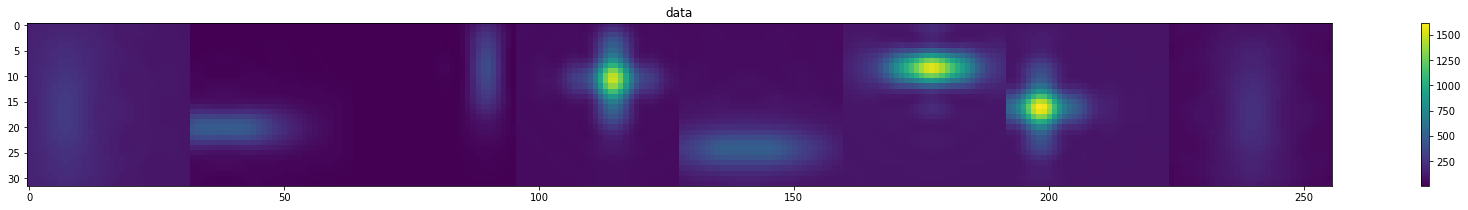

In [4]:
reload(model)
encoder_model = model.IdEncoderModel(len(training_data),
                                    last_out_channels=2)


print(summary(encoder_model, input_size=(128, 1), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

need slicing: False
['x', 'y', 'A', 'sig', 'bg']
Layer (type (var_name))                  Output Shape              Param #
Gaussian2DModel                          --                        --
├─IdEncoderModel (encoder)               [128, 5, 1, 1]            --
│    └─ModuleDict (encoders)             --                        --
│    │    └─Linear (scale)               [128, 5]                  640
│    │    └─ViewModule (view)            [128, 5, 1, 1]            --
├─DirectMapperModel (mapper)             [128, 1, 1, 1]            --
├─Gaussian2DRenderer (renderer)          [128, 1, 32, 32]          --
Total params: 640
Trainable params: 640
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
input shape: (16, 1, 32, 32), output_shape: (16, 1, 32, 32)


d:\github\smlm-dl\smlm_dl\model\base.py:145: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


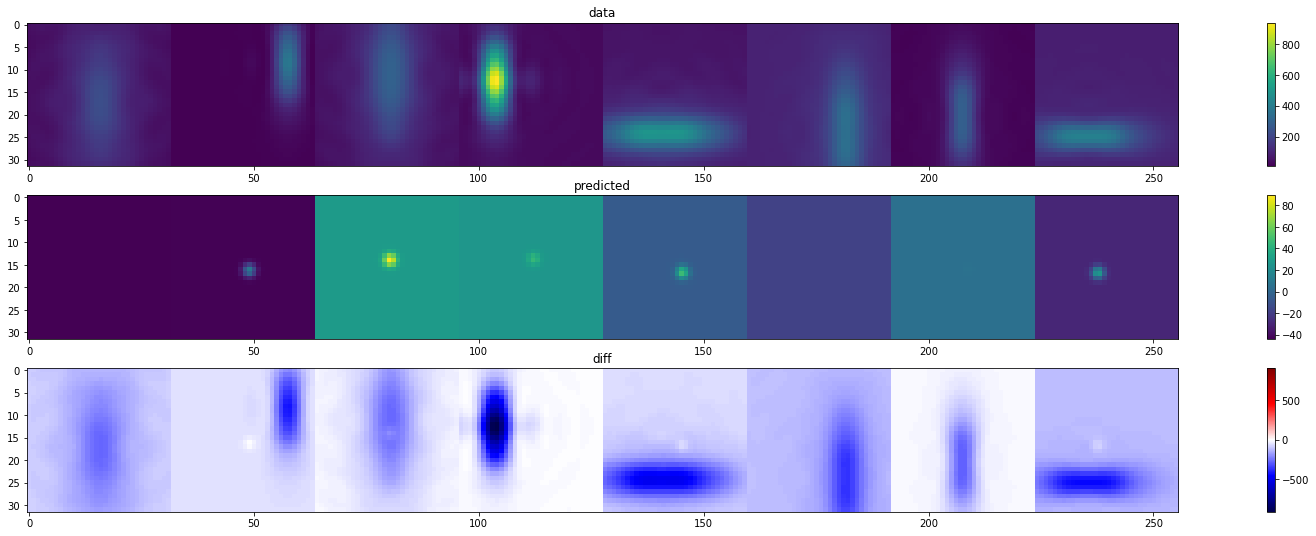

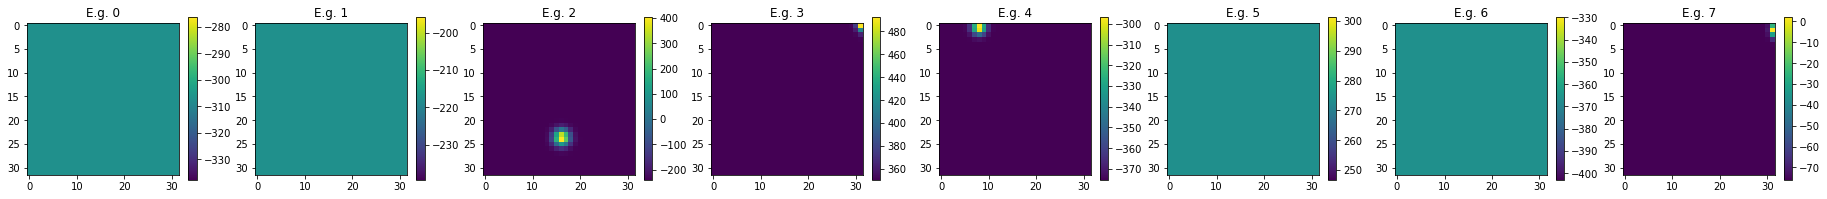

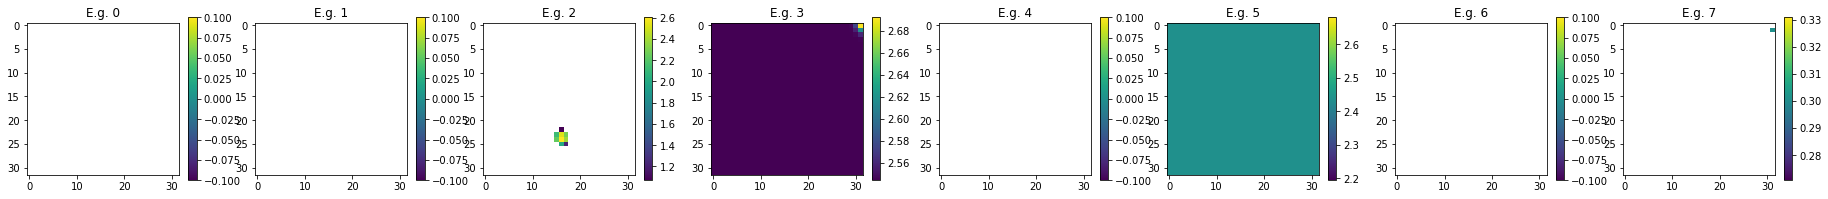

In [5]:
reload(model)

encoder_model = model.Gaussian2DModel(encoder_class=model.IdEncoderModel,
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=1,
                                      encoder_params={"num_img":128,                                                      
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

print(encoder_model.fit_params)


print(summary(encoder_model, input_size=(128, 1), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

['x', 'y', 'A', 'sig', 'bg']
Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [32, 5, 1, 1]             --
│    └─ModuleDict (skips)                     --                        --
│    │    └─Sequential (skip_conv_layer0)     [32, 4, 1, 1]             --
│    │    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    │    └─Conv2d (1)                   [32, 4, 1, 1]             4,100
│    │    │    └─GELU (2)                     [32, 4, 1, 1]             --
│    │    │    └─GroupNorm (3)                [32, 4, 1, 1]             8
│    │    │    └─Conv2d (4)                   [32, 4, 1, 1]             20
│    │    │    └─GELU (5)                     [32, 4, 1, 1]             --
│    │    │    └─Dropout2d (6)                [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                 

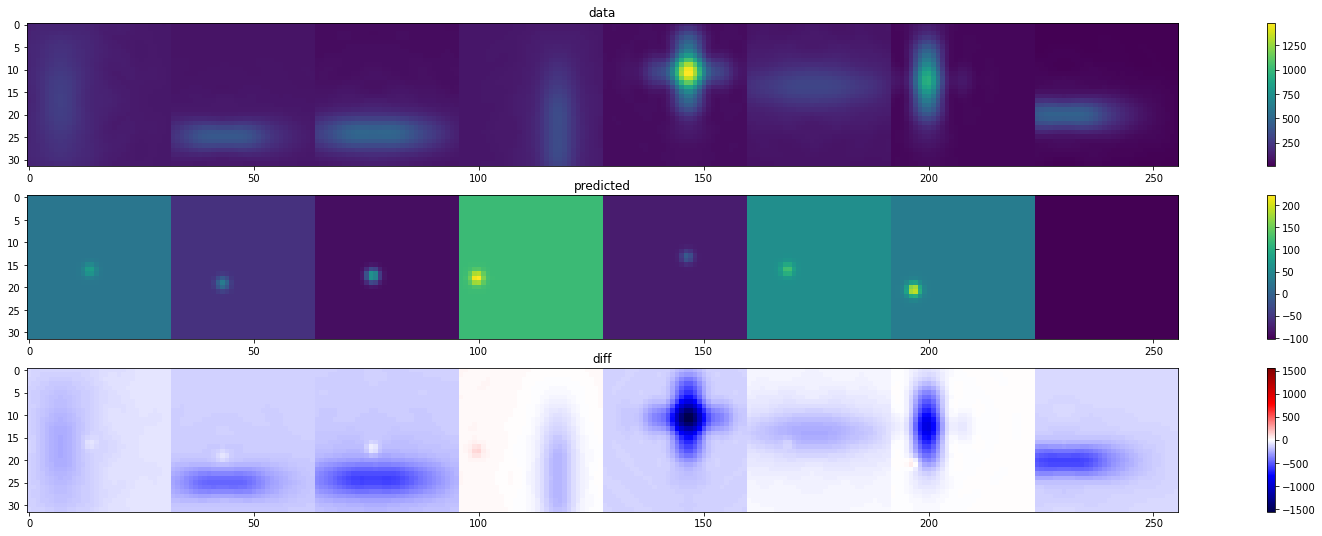

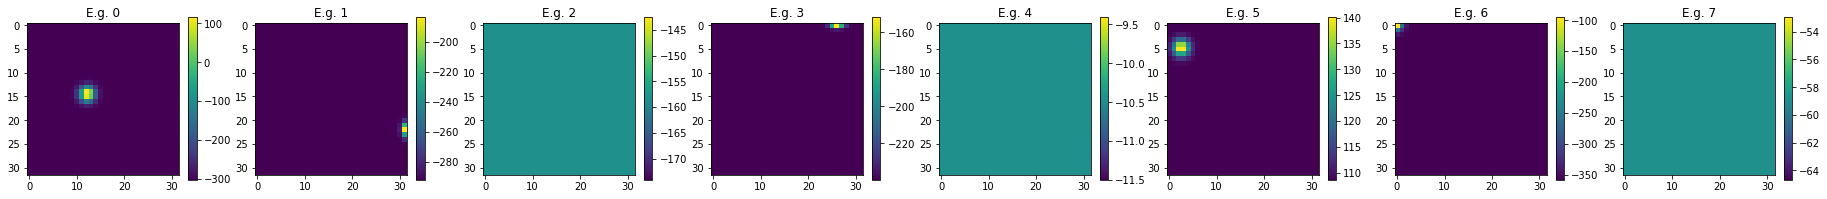

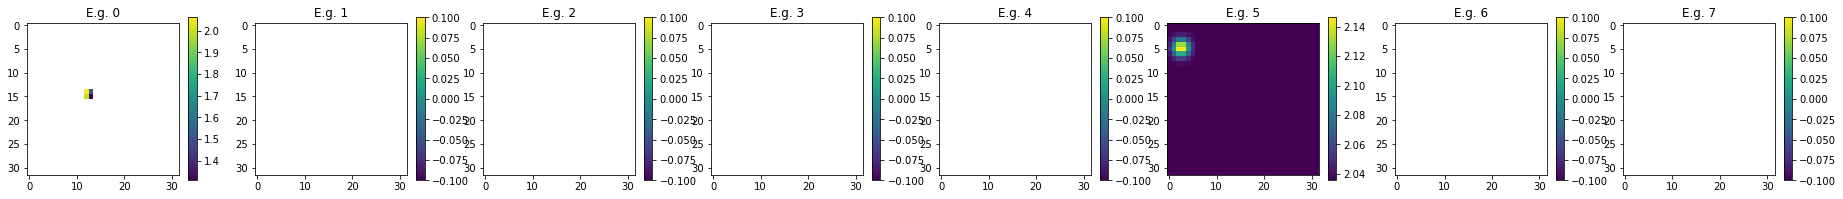

In [6]:
reload(model)

encoder_model = model.Gaussian2DModel(img_size=(32,32),
                                      fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=1,
                                      encoder_params={"depth":3,
                                                      "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     })

print(encoder_model.fit_params)


print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [32, 13, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    │    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│    │    │    └─Conv2d (0)                   [32, 32, 16, 16]          4,640
│    │    │  

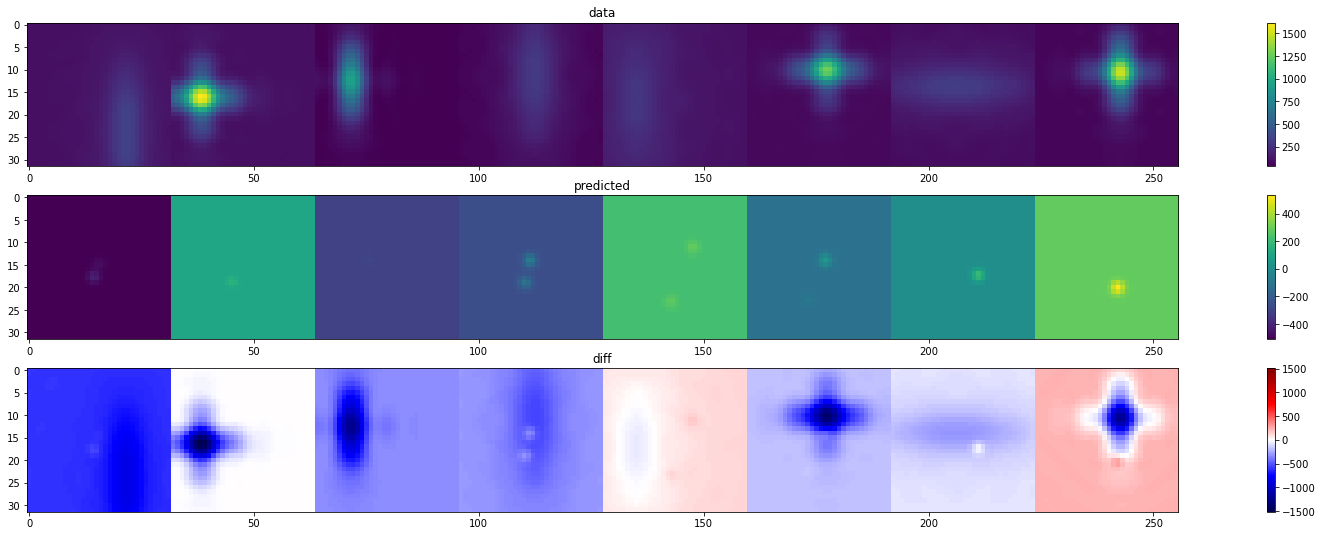

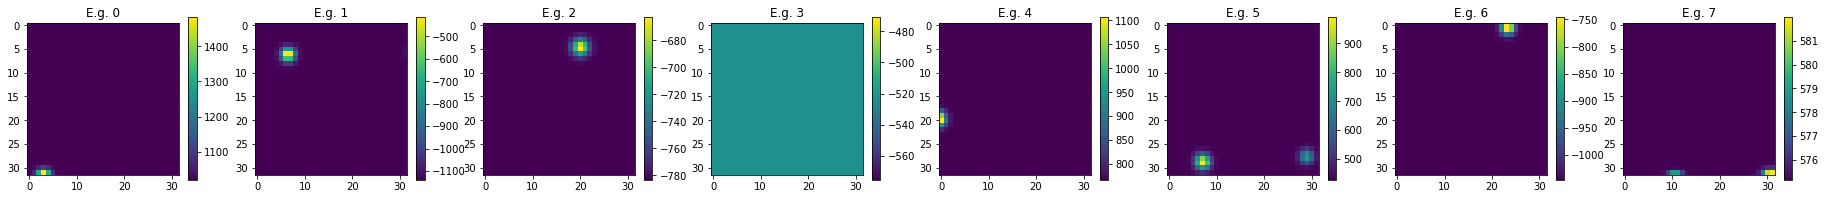

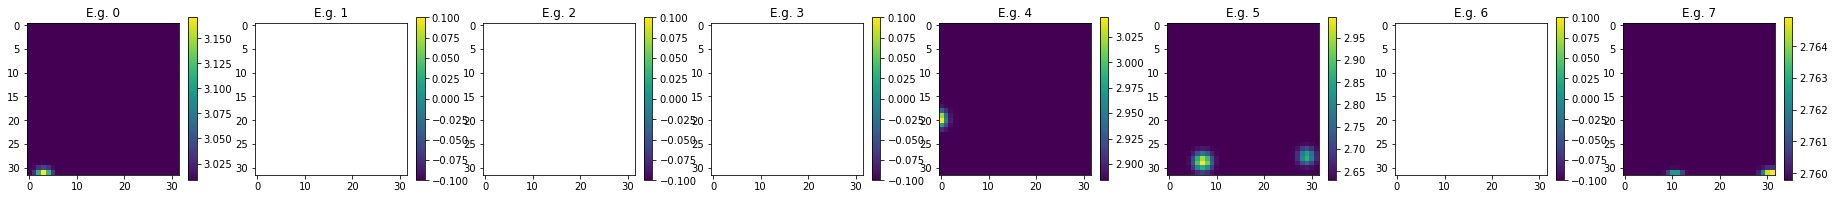

In [7]:
reload(model)

encoder_model = model.Gaussian2DModel(fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},
                                      )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    │    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│    │    │    └─Conv2d (0)                   [32, 32, 16, 16]          4,640
│    │    │  

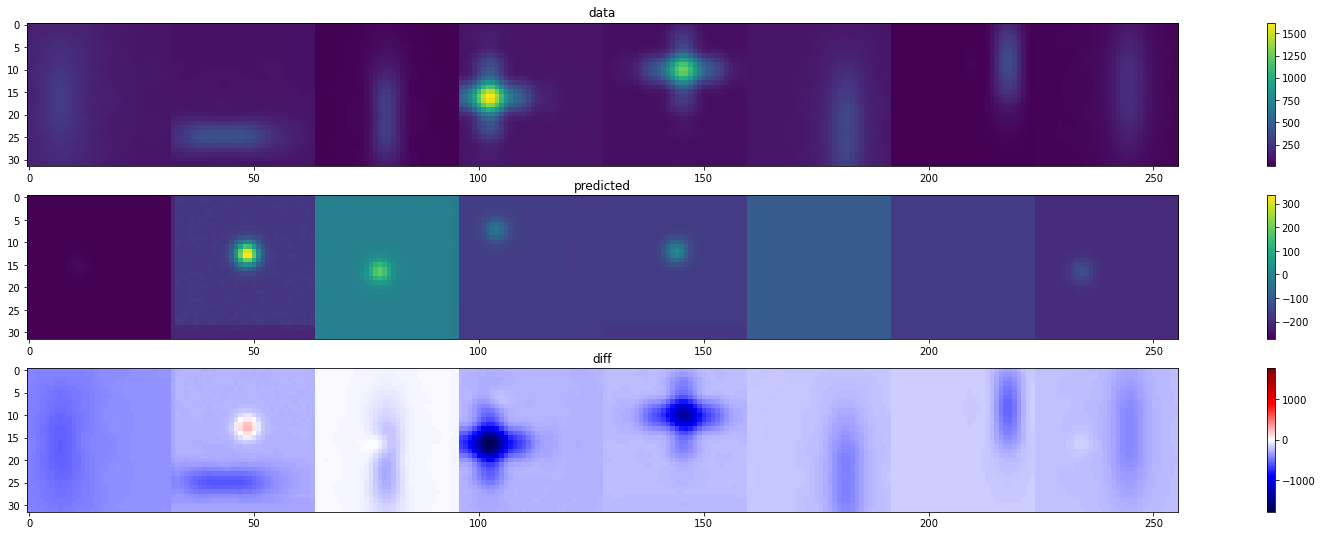

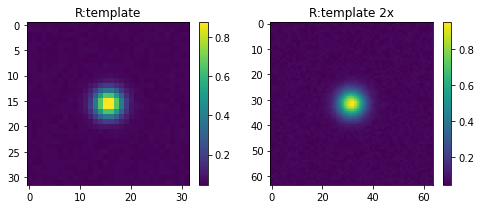

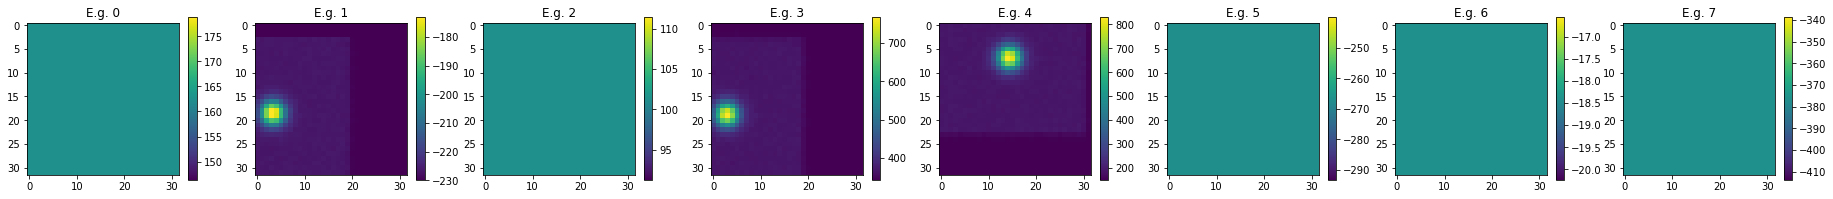

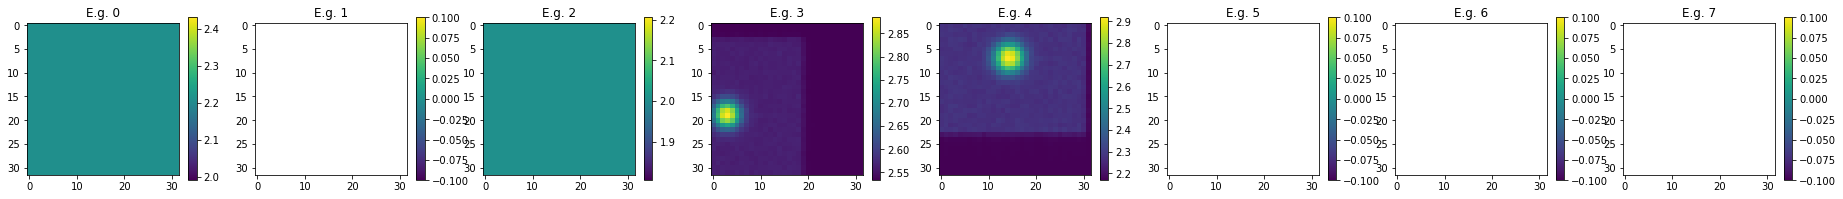

In [8]:
reload(model)

encoder_model = model.Template2DModel(fit_params=['x','y','A','bg'],
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─Template2DRenderer (renderer)               --                        --
│    └─Sequential (template)                  [64, 64]                  --
│    │    └─ParameterModule (0)               [64, 64]                  4,096
│    │    └─GELU (1)                          [64, 64]                  --
│    └─AvgPool2d (template_pooling)           [1, 1, 32, 32]            --
├─DirectConcatFeedbackModel (feedbacker)      [32, 2, 32, 32]           --
│    └─GroupNorm (norm)                       [32, 1, 32, 32]           2
├─ConvImageEncoderModel (encoder)             [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          304
│    │    │    └─

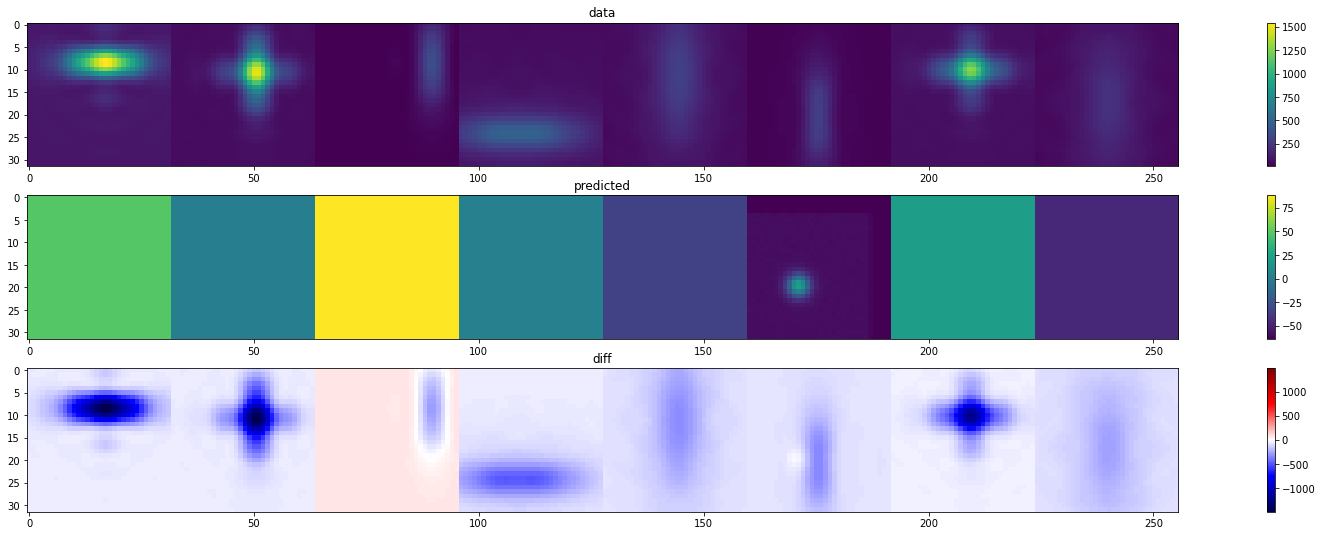

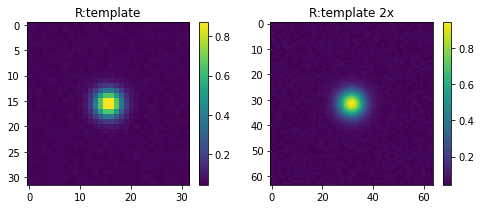

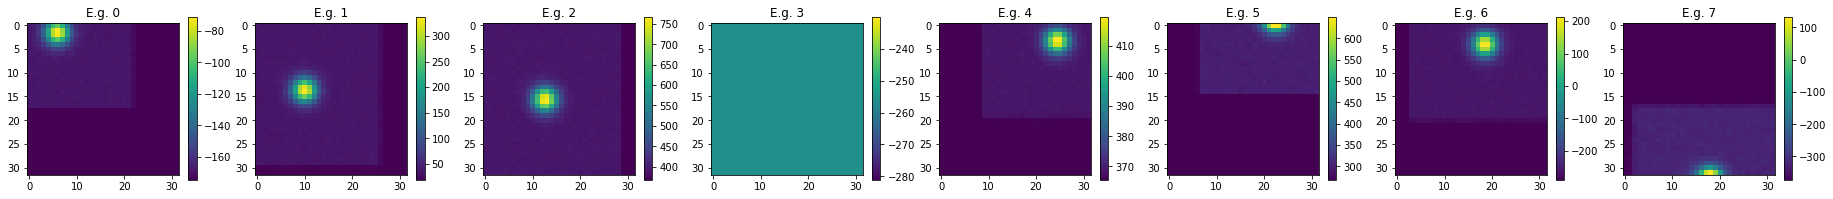

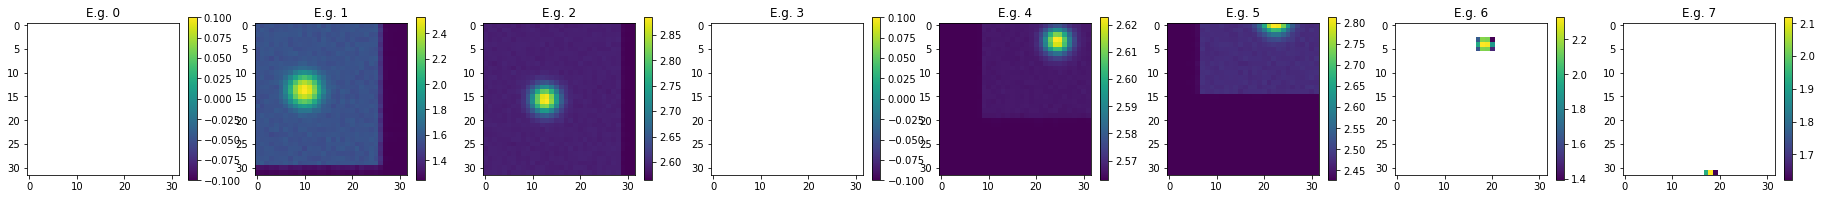

In [9]:
reload(model)

encoder_model = model.Template2DModel(feedback_class=model.DirectConcatFeedbackModel,
                                      fit_params=['x','y','A','bg'],
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [32, 10, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    │    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│    │    │    └─Conv2d (0)                   [32, 32, 16, 16]          4,640
│    │    │  

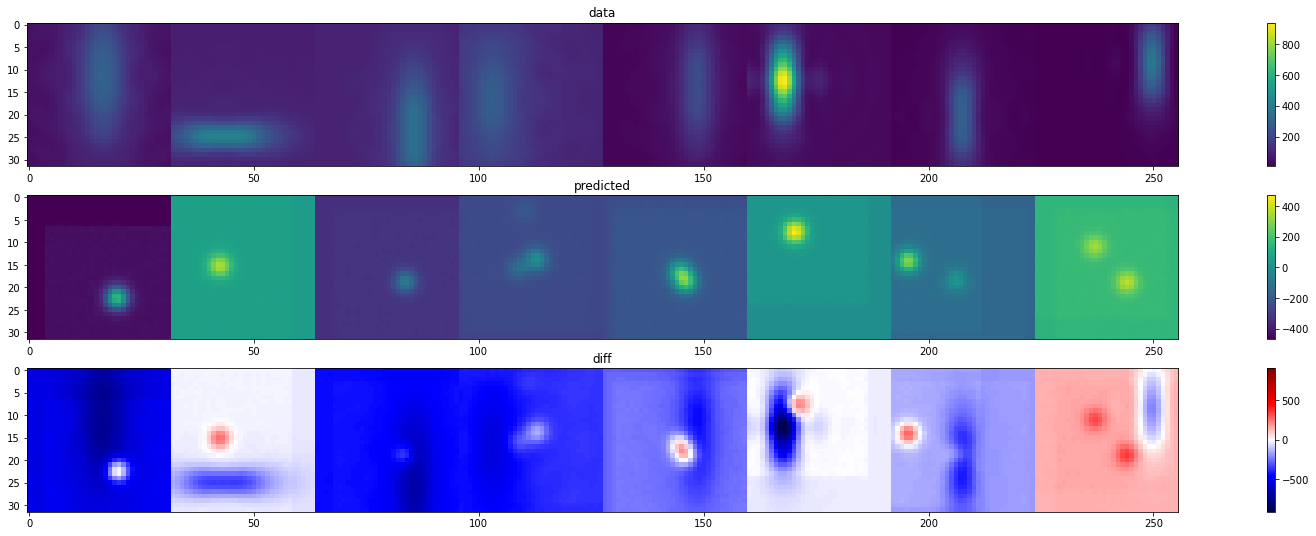

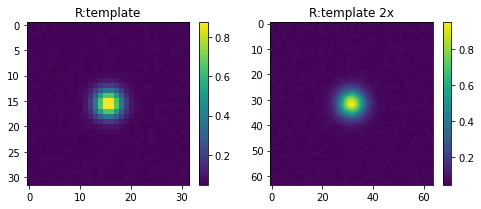

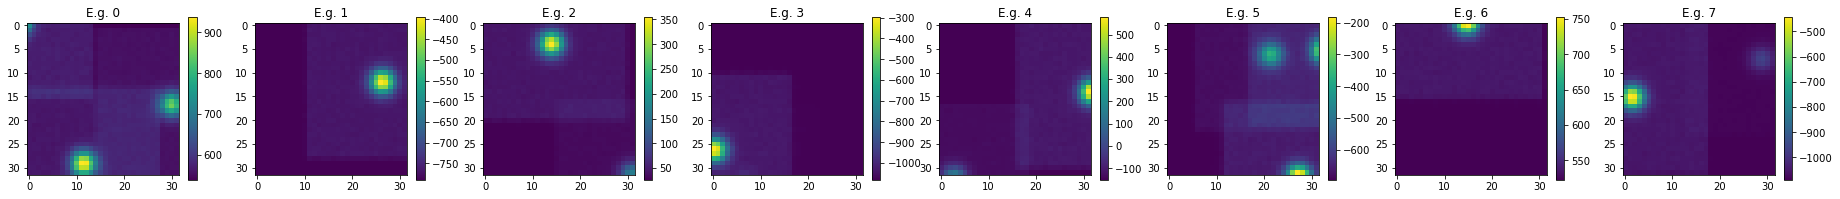

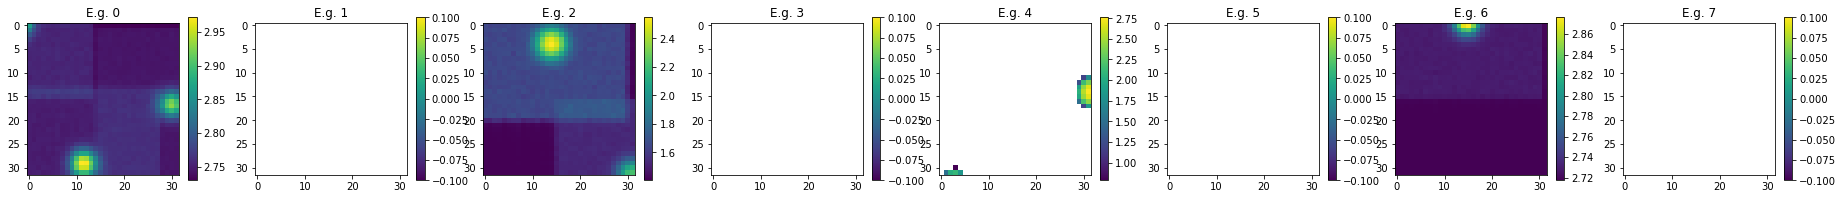

In [10]:
reload(model)


encoder_model = model.Template2DModel(fit_params=['x','y','A','bg',],
                                      max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

input shape: (16, 1, 32, 32), output_shape: (16, 1, 32, 32)


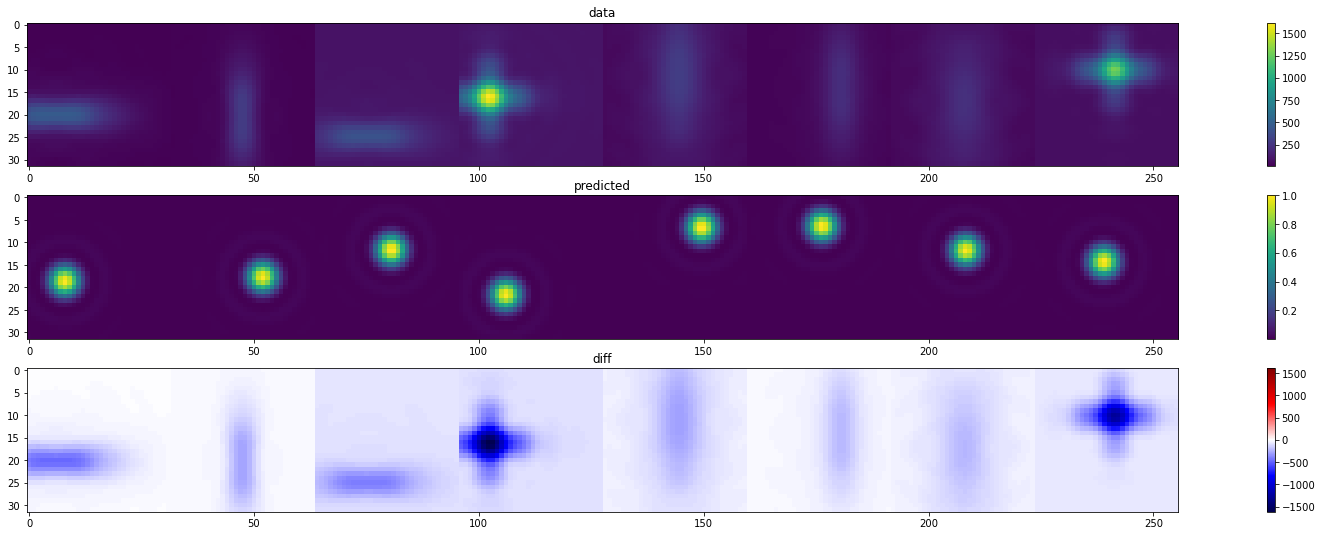

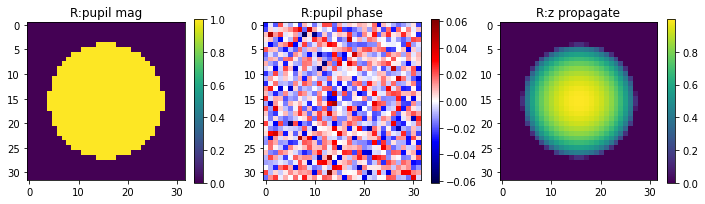

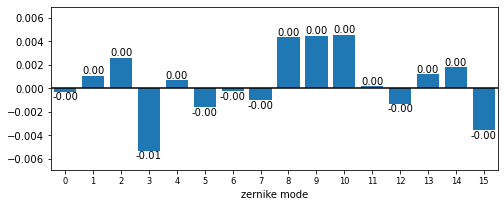

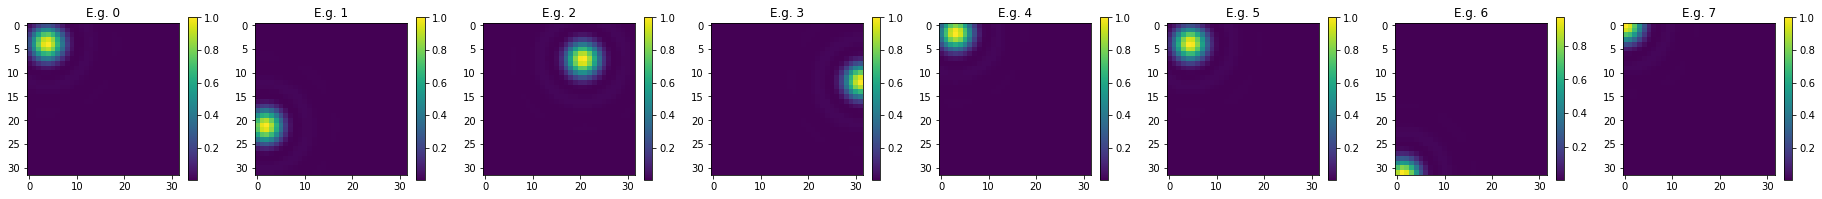

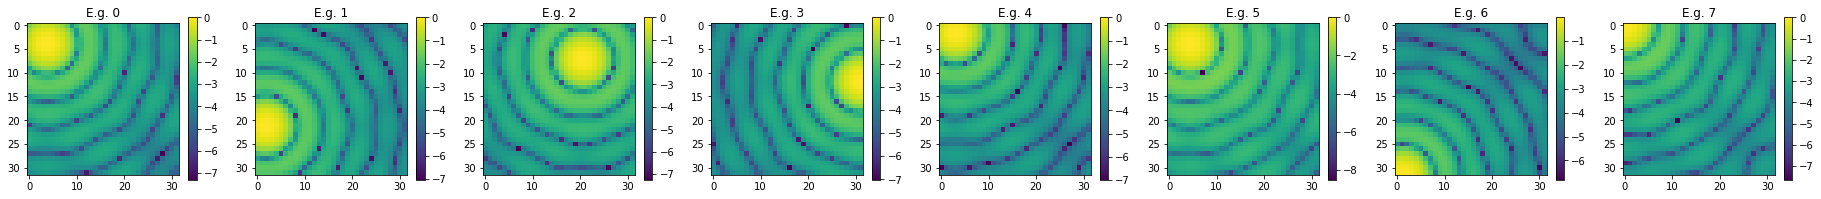

In [11]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y',],
                                           renderer_params={"pupil_params":{'scale':0.75, 'apod':False, 'remove_tilt_tip_defocus':False}},
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},
                                          )
# print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"],))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─ConvImageEncoderModel (encoder)             [1024, 6, 1, 1]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [1024, 16, 16, 16]        --
│    │    │    └─Conv2d (0)                   [1024, 16, 32, 32]        160
│    │    │    └─GELU (1)                     [1024, 16, 32, 32]        --
│    │    │    └─Conv2d (2)                   [1024, 16, 32, 32]        2,320
│    │    │    └─GELU (3)                     [1024, 16, 32, 32]        --
│    │    │    └─MaxPool2d (4)                [1024, 16, 16, 16]        --
│    │    │    └─Dropout2d (5)                [1024, 16, 16, 16]        --
│    │    └─Sequential (conv_layer1)          [1024, 32, 8, 8]          --
│    │    │    └─Conv2d (0)                   [1024, 32, 16, 16]        4,640
│    │    │  

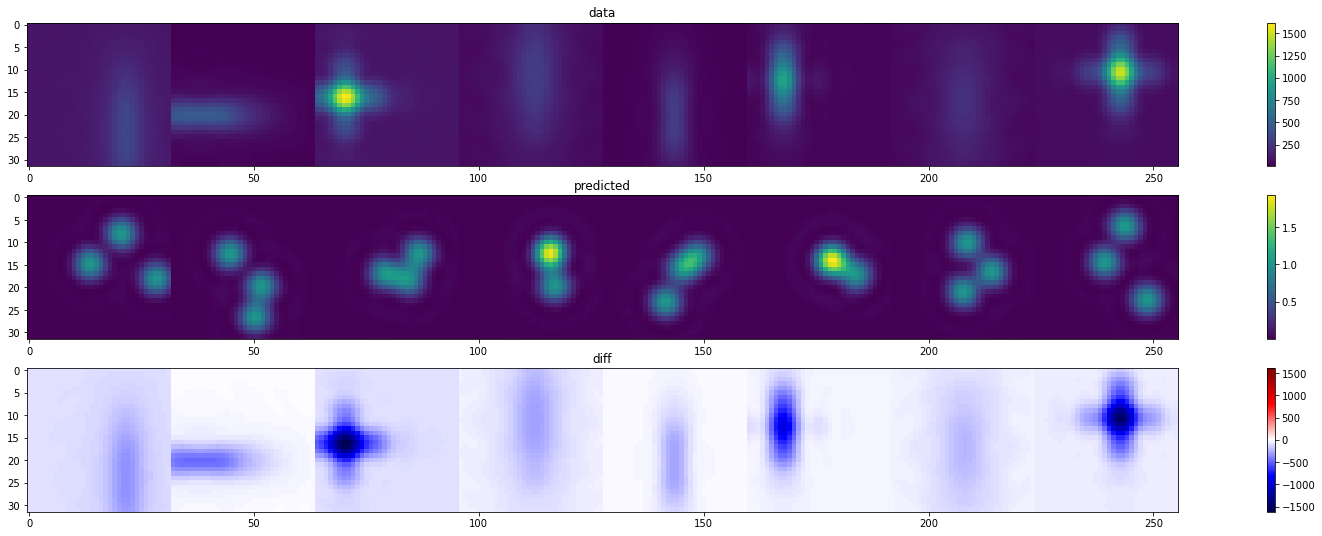

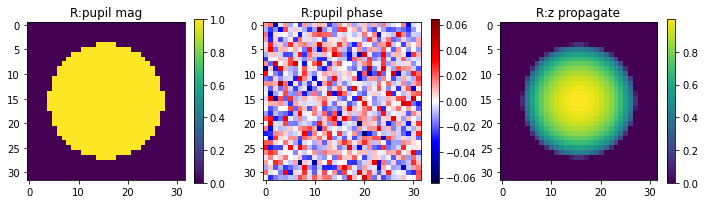

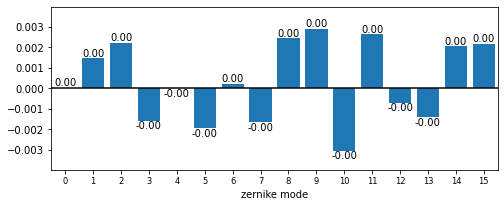

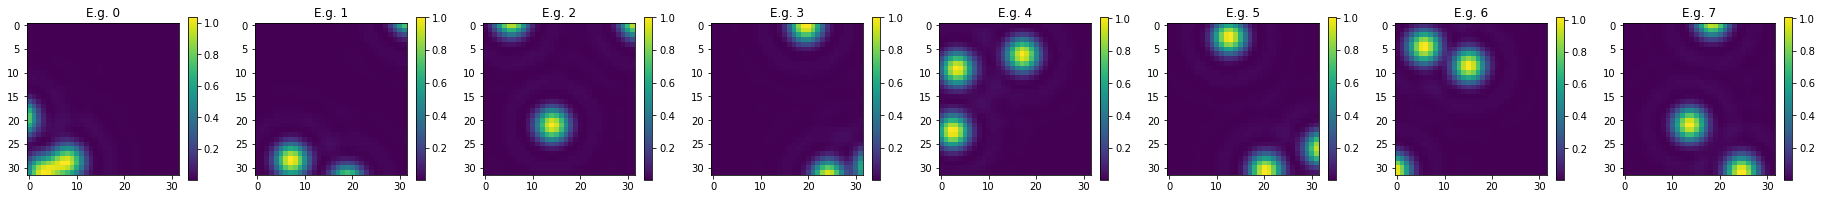

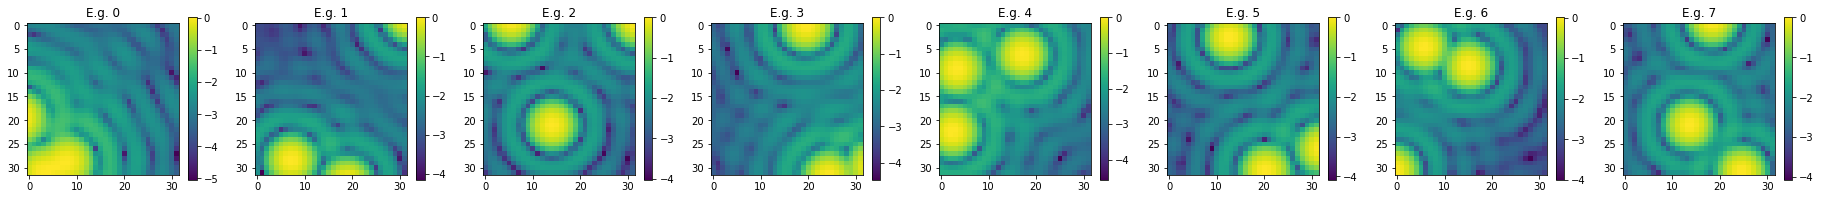

In [12]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y',], max_psf_count=3,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─ConvImageEncoderModel (encoder)             [1024, 5, 1, 1]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [1024, 16, 16, 16]        --
│    │    │    └─Conv2d (0)                   [1024, 16, 32, 32]        160
│    │    │    └─GELU (1)                     [1024, 16, 32, 32]        --
│    │    │    └─Conv2d (2)                   [1024, 16, 32, 32]        2,320
│    │    │    └─GELU (3)                     [1024, 16, 32, 32]        --
│    │    │    └─MaxPool2d (4)                [1024, 16, 16, 16]        --
│    │    │    └─Dropout2d (5)                [1024, 16, 16, 16]        --
│    │    └─Sequential (conv_layer1)          [1024, 32, 8, 8]          --
│    │    │    └─Conv2d (0)                   [1024, 32, 16, 16]        4,640
│    │    │  

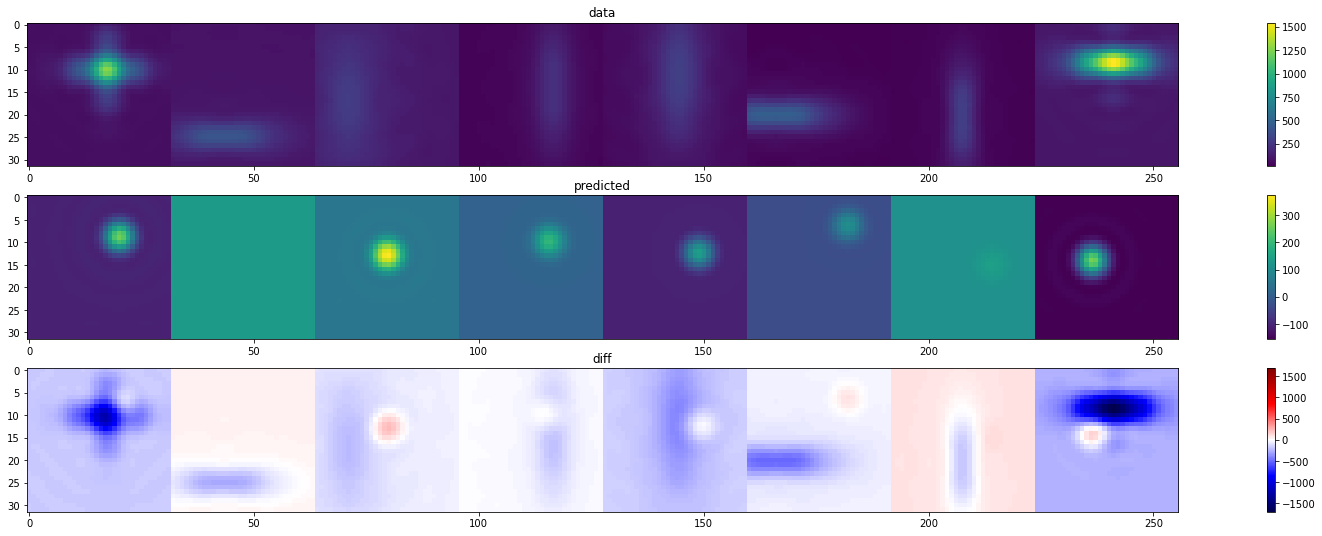

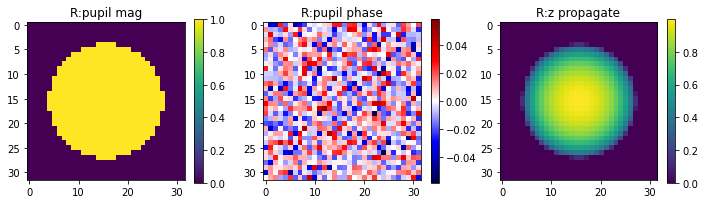

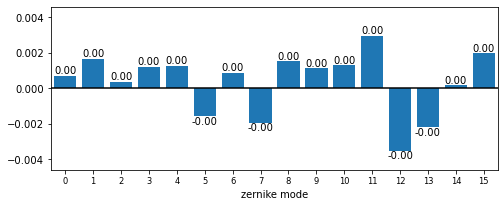

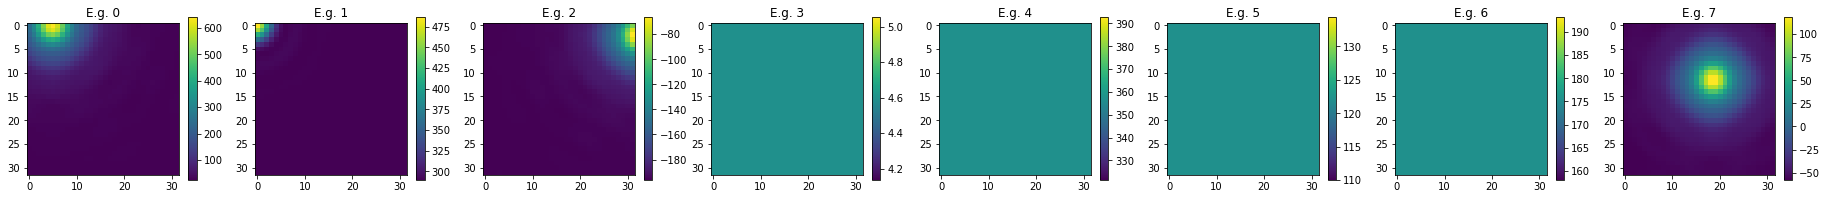

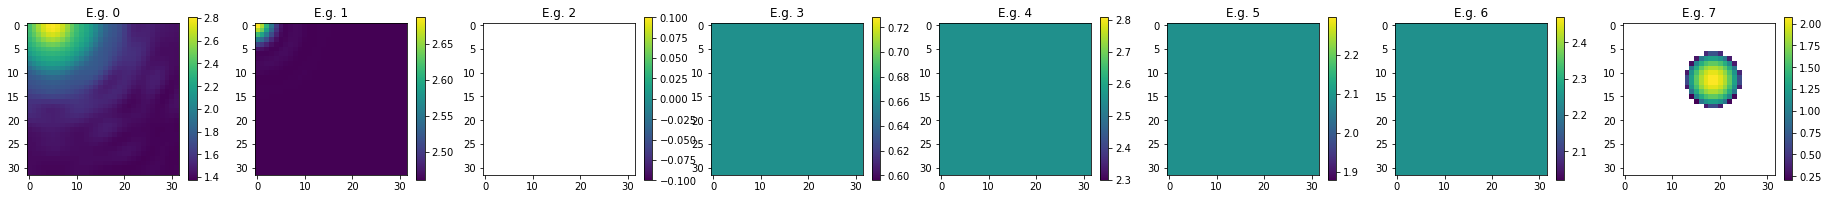

In [13]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


  0%|          | 0/100 [00:00<?, ?it/s]

Early termination after 47 iterations, r2 tol < 0.001 reached
Final loss: 0.000	R2: 0.999
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─ConvImageEncoderModel (encoder)             [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    │    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│

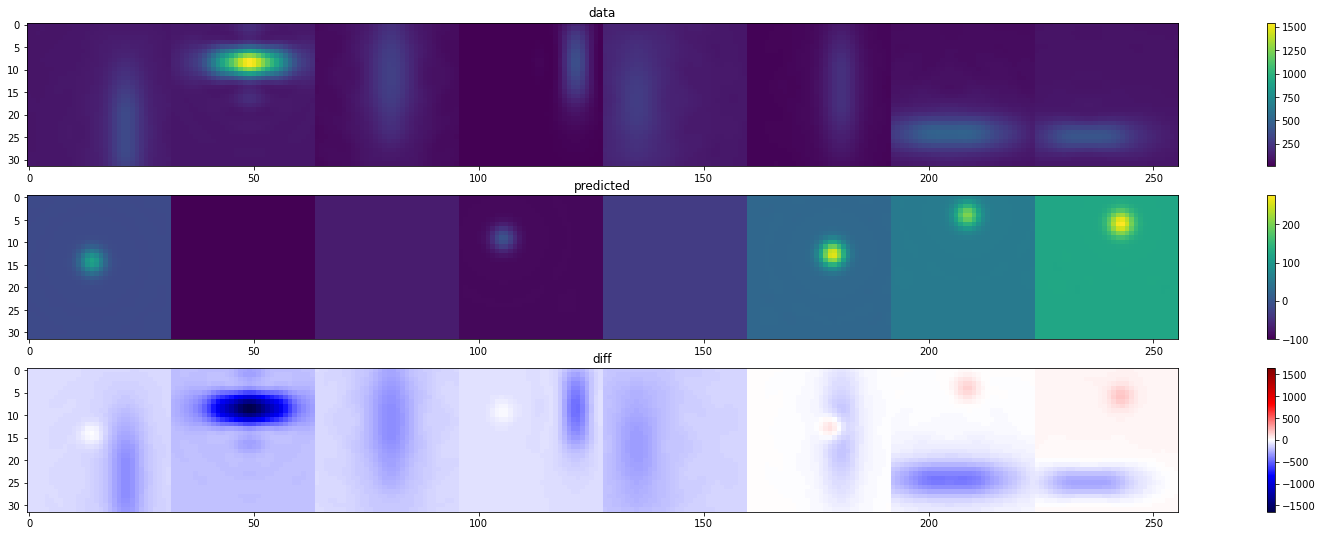

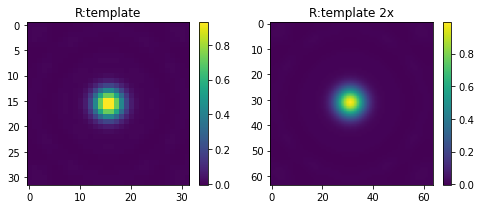

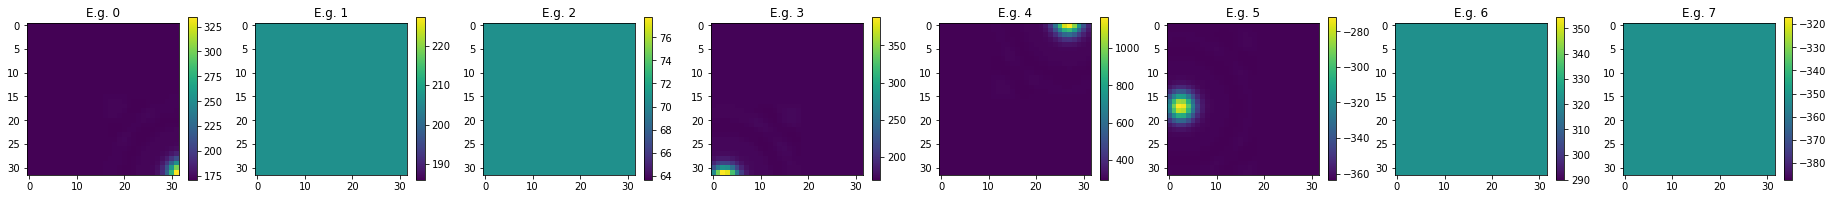

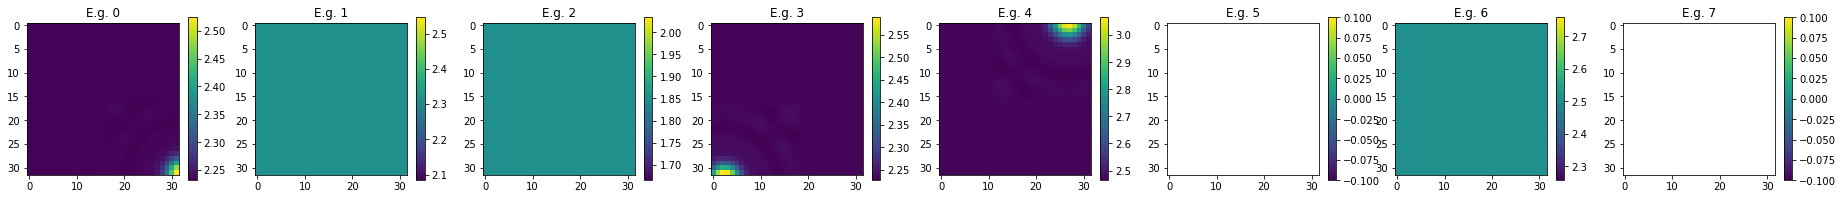

In [14]:
reload(simulate)
reload(model.renderer)
reload(model)

encoder_model = model.BaseFitModel(renderer_class=model.Spline2DRenderer,
                                   encoder_class=model.ConvImageEncoderModel,
                                   fit_params=['x','y','A','bg'],
                                   renderer_params={'k':3,
                                                    # 'template_init':simulate.simulate_centered_gaussian(32,32)
                                                   }
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

  0%|          | 0/50 [00:00<?, ?it/s]

Early termination after 16 iterations, r2 tol < 0.001 reached
Final loss: 0.000	R2: 0.999
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─ConvImageEncoderModel (encoder)             [32, 5, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─Conv2d (0)                   [32, 16, 32, 32]          160
│    │    │    └─GELU (1)                     [32, 16, 32, 32]          --
│    │    │    └─Conv2d (2)                   [32, 16, 32, 32]          2,320
│    │    │    └─GELU (3)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (4)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (5)                [32, 16, 16, 16]          --
│    │    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│

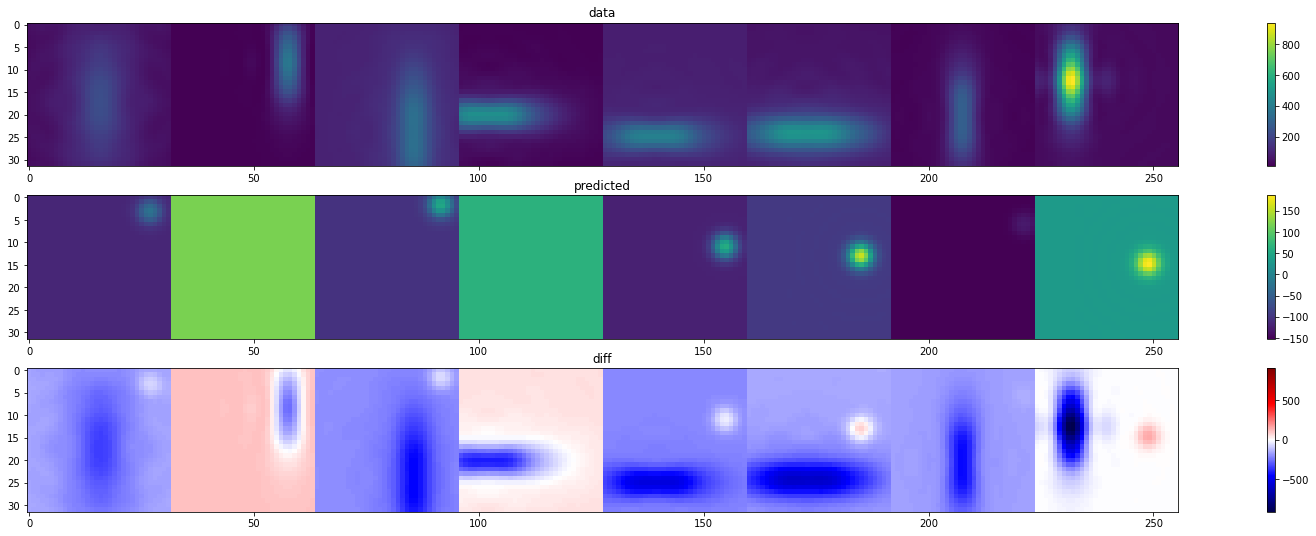

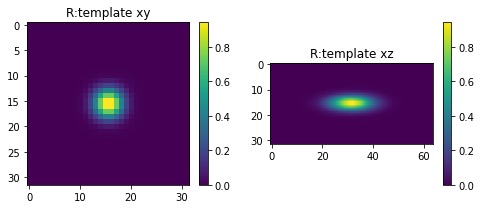

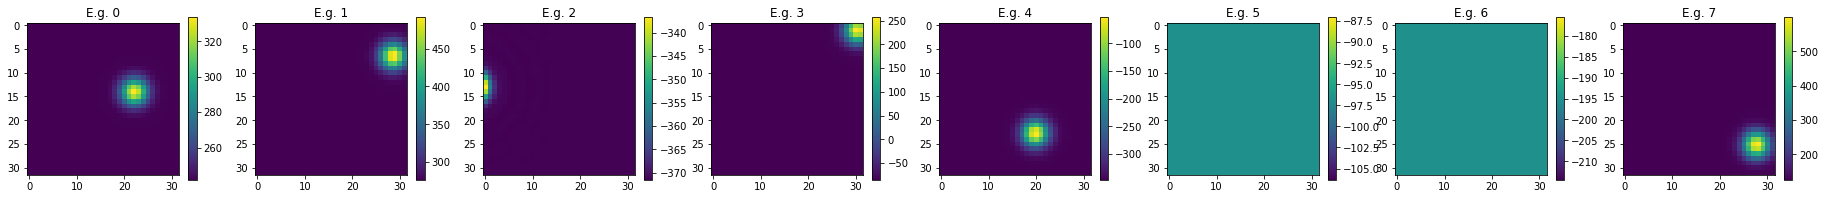

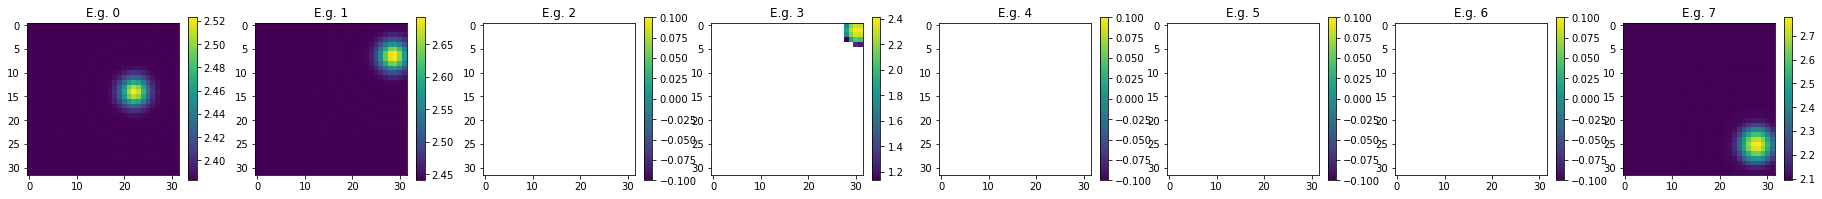

In [15]:
reload(simulate)
reload(model.renderer)
reload(model)

encoder_model = model.BaseFitModel(renderer_class=model.Spline3DRenderer,
                                   encoder_class=model.ConvImageEncoderModel,
                                   fit_params=['x','y','A','bg', 'z'],
                                   renderer_params={'k':3,
                                                    # 'template_init':simulate.simulate_centered_gaussian(32,32)
                                                   }
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─FourierOptics2DRenderer (renderer)          --                        --
│    └─Sequential (pupil_phase)               [32, 32]                  --
│    │    └─ParameterModule (0)               [32, 32]                  1,024
├─DirectConcatFeedbackModel (feedbacker)      [128, 4, 32, 32]          --
│    └─GroupNorm (norm)                       [128, 1, 32, 32]          2
├─ConvImageEncoderModel (encoder)             [128, 5, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─Conv2d (0)                   [128, 16, 32, 32]         592
│    │    │    └─GELU (1)                     [128, 16, 32, 32]         --
│    │    │    └─Conv2d (2)                   [128, 16, 32, 32]         2,320
│    │    │   

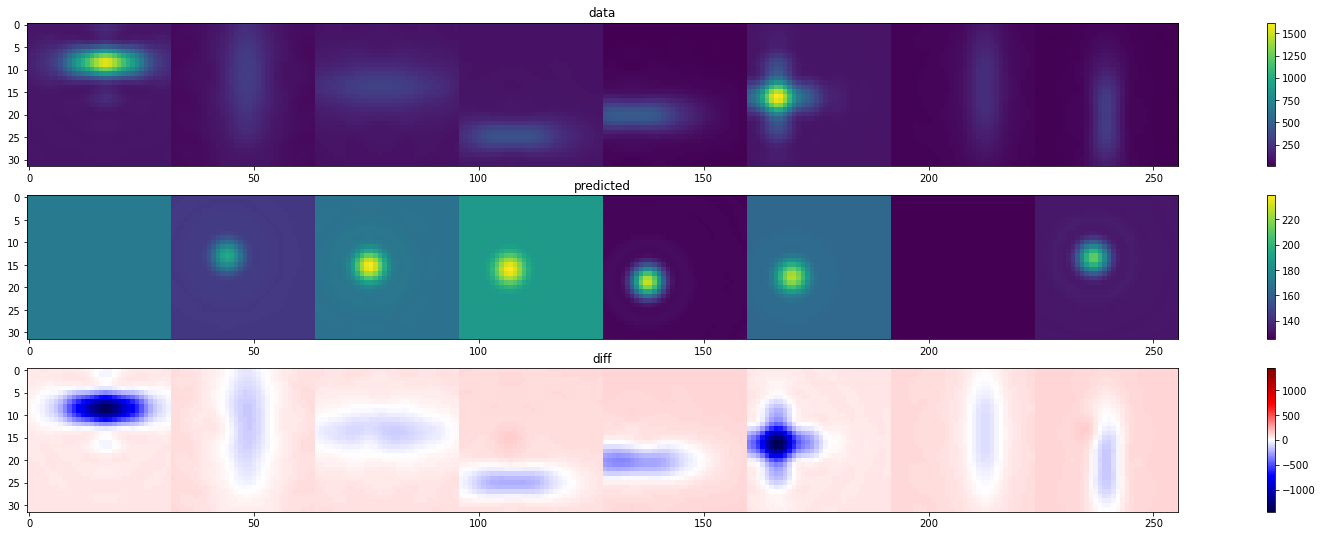

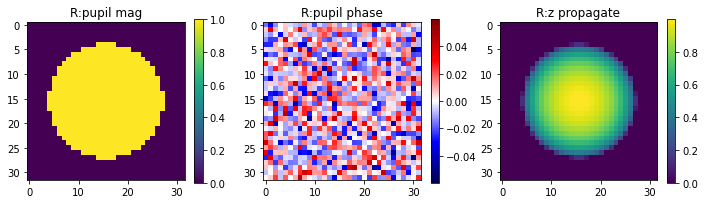

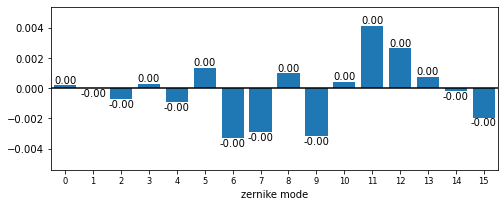

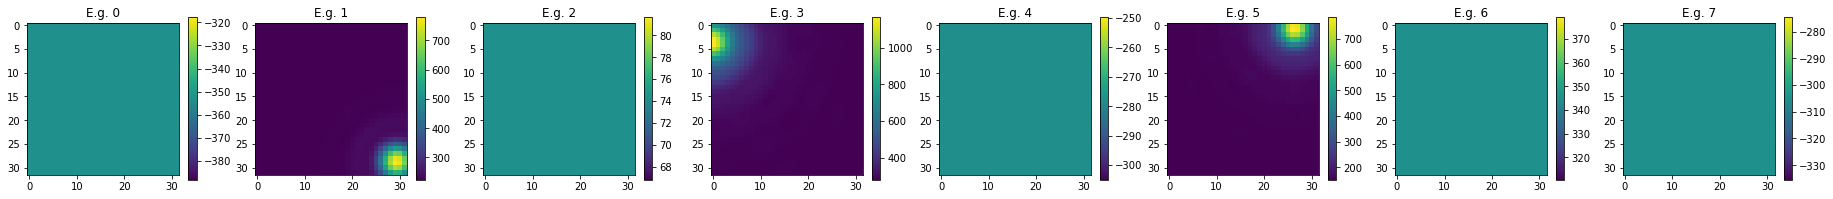

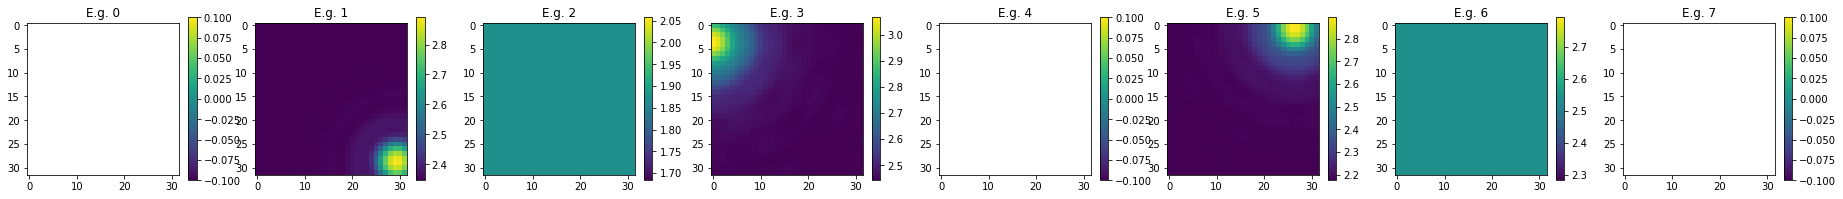

In [16]:
reload(model)

encoder_model = model.FourierOptics2DModel(feedback_class=model.DirectConcatFeedbackModel,
                                           fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(128, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


In [ ]:
reload(model)

encoder_model = model.FourierOptics2DModel(feedback_class=model.DenseFeedbackModel,
                                           fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(128, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


In [ ]:
# reload(trainer)
reload(model)
import torch
from torch import nn
import numpy as np

params_ref_override = {'sig': model.FitParameter(nn.ReLU(), 1, 1, 10, True),
                      'x': model.FitParameter(nn.Identity(), 0, 1, 0, True),
                        'y': model.FitParameter(nn.Identity(), 0, 1, 0, True),
                        'z': model.FitParameter(nn.Tanh(), 0, 2 * np.pi, 0, True),
                        'A': model.FitParameter(nn.ReLU(), 0, 1, 10, True),
                        'bg': model.FitParameter(nn.Identity(), 0, 1, 0, False),
                        'p': model.FitParameter(nn.Sigmoid(), 0, 1, 1, True),
                      }


fitting_model = model.BaseFitModel(encoder_class=model.UnetEncoderModel,
                                   # renderer_class=model.Gaussian2DRenderer,
                                   renderer_class=model.renderer.Template2DRenderer,
                                   mapper_class=model.mapper.CentroidMapperModel,
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','bg'],#'bg'],# 'bg', 'sig'],# 'sig', 'bg'],
                                      max_psf_count=10,
                                   # params_ref_override=params_ref_override,
                                      encoder_params={
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e-4)
# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer)

model.check_model(fitting_model, train_dataloader)

print(summary(fitting_model, input_size=(16, 1, 32, 32), row_settings=["var_names"], depth=4))

# filepath = training.current_state["log_path"]
# print(filepath)
# training = trainer.FittingTrainer.from_model_file(os.path.join(filepath, "model.ptm"))
# training.load_checkpoint(os.path.join(filepath, "checkpoint.ptc"))
# training.train_data_loader = train_dataloader
# training.valid_data_loader = valid_dataloader
# training.train_and_validate(2, label="test")
# model.check_model(fitting_model, )

In [ ]:
reload(dataset)
image_training_data = dataset.SingleImageDataset(skimage.data.human_mitosis()[20:, 20:],
                                                 out_size=(64,64),                                                 
                                                 length=8,
                                                 image_params={'x':[-5, 5], 'y':[-5,5]},
                                                 noise_params={},
                                                 augmentations={},
                                                 normalize=False
                                                )
dataset.inspect_images(image_training_data)

train_image_dataloader = DataLoader(image_training_data,
                                    batch_size=32, shuffle=True)
# print(image_training_data[1][0].shape)

dd = next(iter(train_image_dataloader))
# print(dd[0].shape, dd[1])

In [ ]:
reload(model)

encoder_model = model.Template2DModel(img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)

In [ ]:
reload(model)
print(train_image_dataloader.dataset[0][0].shape)
encoder_model = model.Template2DModel(img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      renderer_params={"template_init":train_image_dataloader.dataset[0][0].mean(0),
                                                       "template_padding":(16,16)},
                                      encoder_params={"depth":4, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)

In [ ]:
reload(model)
print(train_image_dataloader.dataset[0][0].shape)
encoder_model = model.Template2DModel(feedback_class=model.CropAndConcatFeedbackModel,
                                      img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      renderer_params={"template_init":train_image_dataloader.dataset[0][0].mean(0),
                                                       "template_padding":(16,16)},
                                      encoder_params={"depth":4, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)